# Equation solving tools

We distinguish between root finding or solving algebraic equations and solving differential equations.

It is also useful to distinguish between approximate solution using numeric methods and exact solution.

## Exact solution using sympy

We can solve systems of equations exactly using sympy's `solve` function. This is usually done using what is known as the residual form. The residual is simply the difference between the LHS and RHS of an equation, or put another way, we rewrite our equations to be equal to zero:

$$\begin{align}
x + y &= z \\
\therefore x + y - z &= 0
\end{align}
$$


In [1]:
import sympy
sympy.init_printing()

In [2]:
x, y, z = sympy.symbols('x, y, z')

In [3]:
sympy.solve(x + y - z, z)

We can solve systems of equations using `solve` as well, by passing a list of equations

In [4]:
equations = [x + y - z, 
             2*x + y + z + 2,
             x - y - z + 2]
unknowns = [x, y, z]

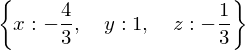

In [5]:
solution = sympy.solve(equations, unknowns)
solution

In [6]:
%%timeit
sympy.solve(equations, unknowns)

100 loops, best of 3: 8.52 ms per loop


Notice that the result is a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries). We can get the individual answers by indexing (using [])

In [7]:
solution[x]

We often need the numeric value rather than the exact value. We can convert to a floating point number using `.n()`

In [8]:
solution[x].n()

Special case: linear systems
============================

For linear systems like the one above, we can solve very efficiently using matrix algebra. The system of equations can be rewritten in matrix form:

$$ A\mathbf{x} = \mathbf{b}$$

In [9]:
equations

In [10]:
A = sympy.Matrix([[1, 1, -1],
                  [2, 1, 1],
                  [1, -1, -1]])
b = sympy.Matrix([[0, -2, -2]]).T

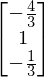

In [11]:
A.solve(b)

CPU times: user 1.56 ms, sys: 104 µs, total: 1.67 ms
Wall time: 1.67 ms


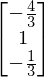

In [12]:
%%time
A.solve(b)

We can repeat the solution using `numpy`. This is considerably faster than using `sympy` for large matrices.

In [13]:
import numpy

In [14]:
A = numpy.matrix([[1, 1, -1],
                  [2, 1, 1],
                  [1, -1, -1]])
b = numpy.matrix([[0, -2, -2]]).T

In [15]:
numpy.linalg.solve(A, b)

matrix([[-1.33333333],
        [ 1.        ],
        [-0.33333333]])

In [16]:
%%time
numpy.linalg.solve(A, b)

CPU times: user 124 µs, sys: 29 µs, total: 153 µs
Wall time: 140 µs


matrix([[-1.33333333],
        [ 1.        ],
        [-0.33333333]])

The numpy version is much faster, even for these small matrices. Let's try that again for a bigger matrix:

In [17]:
N = 100
bigA = numpy.random.random((N, N))

In [18]:
bigb = numpy.random.random((N,))

In [19]:
%%timeit
numpy.linalg.solve(bigA, bigb)

The slowest run took 118.74 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 133 µs per loop


In [20]:
bigsymbolicA = sympy.Matrix(bigA)

In [21]:
bigsimbolicb = sympy.Matrix(bigb)

In [22]:
%%timeit
bigsymbolicA.solve(bigsimbolicb)

1 loop, best of 3: 25.5 s per loop


Wow! That takes more than a million times longer.

Nonlinear equations
===================

In some cases, sympy can solve nonlinear equations exactly:

In [23]:
x, y = sympy.symbols('x, y')

In [24]:
sympy.solve([x + sympy.log(y), y**2 - 1], [x, y])

But sometimes nonlinear equations don't admit a closed-form solution:

In [25]:
unsolvable = x + sympy.cos(x) + sympy.log(x)
sympy.solve(unsolvable, x)

NotImplementedError: multiple generators [x, cos(x), log(x)]
No algorithms are implemented to solve equation x + log(x) + cos(x)

In such cases we need to use approximate (numeric) solutions.

In [31]:
import scipy.optimize

The function `sympy.lambdify` can be used to build a function which evaluates `sympy` expressions numerically:

In [32]:
unsolvable_numeric = sympy.lambdify(x, unsolvable)

In [33]:
unsolvable_numeric(50)

This is the kind of thing we can pass to `scipy.optimize.fsolve`

In [34]:
scipy.optimize.fsolve(unsolvable_numeric, 0.1)

array([ 0.28751828])

`fsolve` works for multiple equations as well, just return a list:

In [35]:
def multiple_equations(unknowns):
    x, y = unknowns
    return [x + y - 1,
            x - y]

In [36]:
multiple_equations([1, 2])

In [37]:
first_guess = [1, 1]
scipy.optimize.fsolve(multiple_equations, first_guess)

array([ 0.5,  0.5])

## Downsides of numerical solution

Remember the downsides of numerical solution:

1. Approximate rather than exact
2. Requires an initial guess
3. Slower to solve the equation every time rather than solving it once and then substituting values.
4. Typically only finds one solution, even if there are many.

Differential equations
======================

Now for differential equations. Sympy can solve some differential equations analytically:

We'll solve the "classic" tank problem:

$$\begin{align}
F_{out} &= kh\\
\frac{\mathrm{d}h}{\mathrm{d}t} &= \frac{1}{A}\left(F_{in} - F_{out}\right)\\
\end{align}
$$


In [38]:
h = sympy.Function('h')  # This is how to specify an unknown function in sympy
t = sympy.Symbol('t', positive=True)

In [39]:
Fin = 2
K = 1
A = 1

In [40]:
Fout = K*h(t)
Fout

We use `.diff()` to take the derivative of a function.

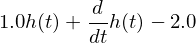

In [41]:
de = h(t).diff(t) - 1/A*(Fin - Fout)
de

Here we calculate the general solution

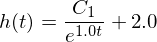

In [42]:
solution = sympy.dsolve(de)
solution

We need a name for the constant of integration which Sympy created. Expressions are arranged as trees with the arguments as elements. We can navigate this tree to get the C1 element:

In [44]:
C1 = solution.rhs.args[1].args[0]

We can find the value of the constant by using an initial value:

In [45]:
h0 = 1

In [47]:
constants = sympy.solve(solution.rhs.subs({t: 0}) - h0, C1)
constants

Let's see what that looks like

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

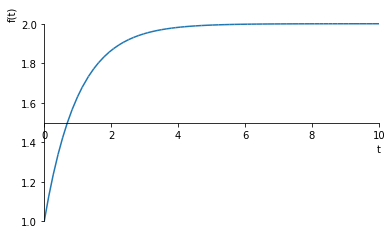

In [51]:
sympy.plot(solution.rhs.subs({C1: constants[0]}), (t, 0, 10))

We can also solve differential equations numerically using `scipy.integrate.odeint`:

In [54]:
import scipy.integrate

In [52]:
def dhdt(h, t):
    Fout = K*h
    return 1/A*(Fin - Fout)

In [55]:
ts = numpy.linspace(0, 10)

In [56]:
h = scipy.integrate.odeint(dhdt, h0, ts)

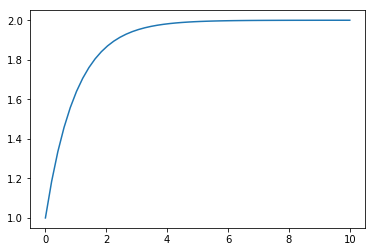

In [57]:
plt.plot(ts, h)